# SiMFS-Tk Example: Single molecule diffusion

This example demonstrates the full simulation of a single molecule including excitation and detection focus functions. This example is the base for many extensions.

### Components

- ``simfs_dif``
- ``simfs_buf``
- ``simfs_exi``
- ``simfs_det``
- ``simfs_ph2``
- ``simfs_spl``

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

from pysimfs import *

All simfs components found in /opt/SiMFS-Tk/SiMFS-core/build/src/components/.


### Step 1: Diffusion

First we create a diffusion component, we discard the collisions and write the coordinates to ``coords``

In [2]:
dif = Diffusion(
    experiment_time=1,
    radius=2e-6,
    half_height=3e-6,
    diffusion_coefficient=4.35e-10,
    coordinate_output='coords', 
    collision_output=os.devnull
)

### Step 2: Duplicate coordinates

Since we want to calculate the excitation and detection efficiency in parallel at each position, we need to duplicate the coordinate data on the fly. We use ``simfs_buf`` for this purpose wich just copies an input stream into multiple outputs. It is basically an implementation of UNIX ``tee``.

In [3]:
buf = CoordinateBuffer(
    input='coords', 
    outputs=['coords_exi', 'coords_det']
)

### Step 3: Excitation

We use the modified gauss function called ``XYGaussZExp`` here with a power of 50 µW. We take one of the 2 coordinate streams as input.

In [4]:
exi = Excitation(
    input='coords_exi',
    type='XYGaussZExp',
    wavelength=488e-9,
    power=50e-6,
    output='exi'
)

### Step 4: Detection efficiency

We take the same focus function for detection with altered (larger) waist parameters and the other coordinate stream as input.

In [5]:
det = Detection(
    input='coords_det',
    type='XYGaussZExp',
    shape={
        'waist_xy': 300e-9,
        'waist_z': 800e-9
    },
    output='det'
)

### Step 5: Photophysics

The photophysics simulation is a basic three-state system. The emission edge write photons to the ``emi`` output. To react to the laser excitation, the ``exi`` edge has rate input pointed to ``exi``, our excitation photon flux density stream. The ``epsilon`` value is a molar absorption coefficient to convert the photon flux density into an actual rate.

In [6]:
ph2 = Fluorophore(
    initial_state='S0',
    jablonsky = {
        'emi': {
            'from': 'S1',
            'output': 'emi',
            'rate': 1e+8,
            'to': 'S0'
        },
        'exi': {
            'from': 'S0',
            'rate': {
                'input': 'exi',
                'epsilon': 73000
            },
            'to': 'S1'
        },
        'isc': {
            'from': 'S1',
            'rate': 5e+6,
            'to': 'T1'
        },
        'risc': {
            'from': 'T1',
            'rate': 5e+6,
            'to': 'S0'
        }
    }
)

### Step 6: Detection

Finally the actual detection is performed by a ``simfs_spl`` instance. The detection efficiency stream and the raw emission stream from ``simfs_ph2`` is read in and the detected photons are written to ``detected.dat``. All others are discarded. 

In [7]:
spl = Splitter(
    efficiency_input='det',
    photon_input='emi',
    accepted_output='detected.dat',
    rejected_output=os.devnull
)

## Running

With all components in place, we can start the run.

**Note: It is generally a good practise to add components in one single step (a cell in the notebook) to avoid accidental duplications and allow error-free re-exection.**


In [8]:
with Simulation() as S:
    S.add(dif)
    S.add(buf)
    S.add(exi)
    S.add(det)
    S.add(ph2)
    S.add(spl)
    log = S.run()
    photons = S.get_results()['detected.dat']

Folder ./pysimfs_data exists.
Started simulation with 6 component processes.
Simulation completed after 2.77 seconds.


## Inspecting the result

Let's look at the photon data with a timetrace. We bin the 1 second data in 100µs to see the burst pattern. 

Text(0, 0.5, '# photons / 100µs')

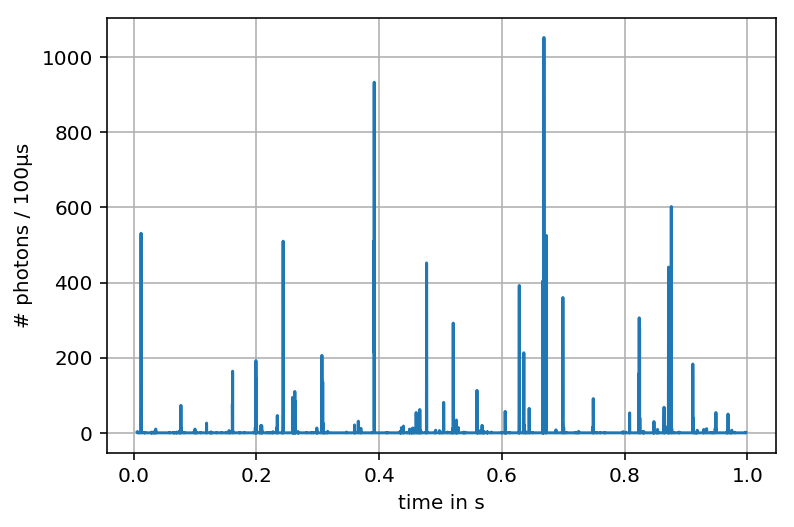

In [9]:
hist, bins = np.histogram(photons, 10000)
plt.plot(bins[:-1], hist)
plt.grid()
plt.xlabel('time in s')
plt.ylabel('# photons / 100µs')

### Correlation

We can look further into the data with a quick correlation. We are going to use [``pycorrelate``](https://pypi.org/project/pycorrelate/) to do so:

In [10]:
from pycorrelate import pcorrelate

In [11]:
tau = np.logspace(-10, -2, 128)
cor = pcorrelate(photons, photons, tau, normalize=True)

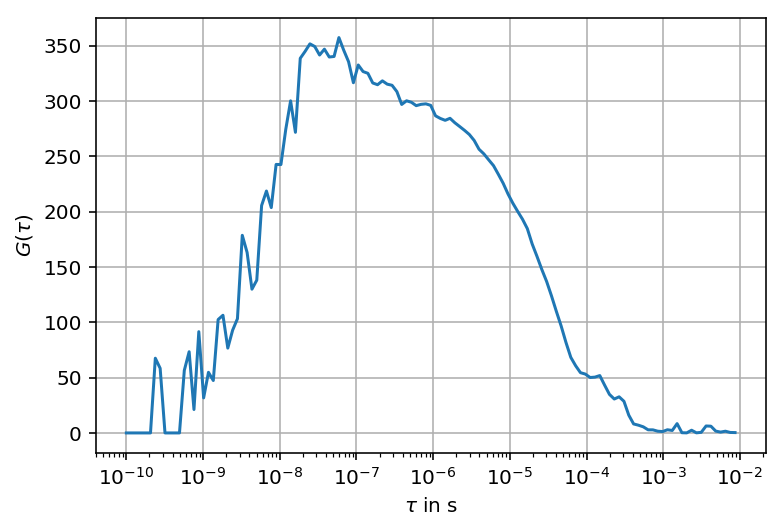

In [12]:
plt.semilogx(tau[:-1], cor)
plt.grid()
_ = plt.xlabel(r'$\tau$ in s')
_ = plt.ylabel(r'$G(\tau)$')

You can see the whole range of fluctuations from antibunching and triplet dynamics up to the diffusion time. Play around with the jablonsky diagram, focus paramters or excitation power to see the changes in different regions of the curve.